# Pyiron workflows: quickstart

You can start converting python functions to `pyiron_workflow` nodes by wrapping them with decorators accessible from our single-point-of-entry, the `Workflow` class:

In [1]:
from pyiron_workflow import Workflow

## From function to node

Let's start with a super simple function that only returns a single thing

In [2]:
@Workflow.wrap.as_function_node
def AddOne(x):
    y = x + 1
    return y

node = AddOne()

This node object can be run just like the function it wraps

In [3]:
node(42)

43

But is also a class instance with input and output channels (note that here the output value takes its name based on what came after the `return` statement)

In [4]:
node.inputs.x = 0
node.run()
node.outputs.y.value

1

So other than being delayed, these nodes behave a _lot_ like the regular python functions that wrap them. Notice that the node object has named inputs _and_ outputs -- unlike a regular function for which only inputs are named. 

These are "data channels" for the node. The names of input channels is obvious from the signature of the decorated function. We'll see later how to pass specific output names to the `as_function_node` decorator, but in this case `y` was just scraped automatically from the text of the `return y` statement --  a good encouragement to use meaningful variable names and then return them.

Just like regular functions, we can nest function nodes together -- the result is still delayed, so we need to call the nested object at the end:

In [5]:
calculation = AddOne(AddOne(AddOne(2)))
calculation()

5

But they are actually nodes, and what we saw above is just syntactic sugar for building a _graph_ connecting the inputs and outputs of the nodes:

In [6]:
n1 = AddOne()
n2 = AddOne()
n3 = AddOne()

n2.inputs.x = n1.outputs.y
n3.inputs.x = n2.outputs.y

n1.inputs.x = 0
n3()

3

In the special case that a node has only _one_ output channel (i.e. only one return value in the decorated function), this object will fall back on trying to perform operations on that output channel! Combining this with the syntactic sugar for using the function signature to set input values, we can equivalently write the example above as:

In [7]:
n1 = AddOne(x=0)
n2 = AddOne(x=n1)
n3 = AddOne(x=n2)
n3()

3

Let's come back to how output data channels are named. Sometimes you want to return something that looks "ugly" -- like `x + 1` in the example above -- or perhaps you're making a function node out of a function you didn't write and don't have the power to change. In the former case you can create a new local variable that looks "pretty" (`y = x + 1` above) and return that, but in either case you can pass an output label to the decorator. Nodes also pull hints and defaults from the function they wrap. We can re-write our example above to leverage all of this:

In [8]:
@Workflow.wrap.as_function_node("y")
def AddOne(x: int) -> int:
    return x + 1

AddOne.preview_io()

{'inputs': {'x': (int, NOT_DATA)}, 'outputs': {'y': int}}

## Putting it together in a workflow

We can work with nodes all by themselves, but since the whole point is to connect them together to make a computation graph, we can get extra tools by intentionally making these children of a `Workflow` node.

The `Workflow` class not only gives us access to the decorators for defining new nodes, but also lets us access a core set of existing nodes. Let's put together a workflow that uses both an existing node from the creator, and another function node that has multiple return values. This function node will also exploit our ability to name outputs (in the decorator argument) and give type hints (in the function signature, as usual). 

In addition to using output channels (or nodes, if they have only a single output) to make connections to input channels, we can perform many (but not all) other python operations on them to dynamically create new nodes! Below see how we do math and indexing right on the output channels:

In [9]:
wf = Workflow("my_workflow")

@Workflow.wrap.as_function_node("range", "length")
def Range(n: int) -> tuple[list[int], int]:
    """
    Two outputs is silly overkill, but just to demonstrate how Function nodes work
    """
    r = range(n)
    return list(r), len(r)


wf.range = Range()
wf.last_square = wf.range.outputs.range[-1]**2

We also can visualize the workflow to see its constituents and connections:

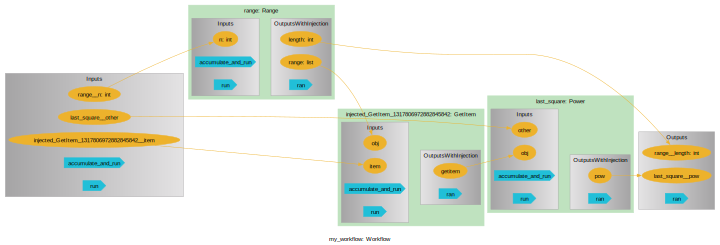

In [10]:
wf.draw(size=(10,10))

We can see that the workflow automatically exposes unconnected IO of its children and gives them a name based on the child node's name and that node's IO name. Further, the math and indexing we do automatically injects new nodes after the output. Note that even though we perform a slice on `wf.arange.outputs.arange` twice, only a single node is created and it simply gets reused -- the graph is aware of all the dynamically injected nodes and reuses them like this for computational efficiency.

Let's run our workflow and look at the result:

In [11]:
wf(range__n=5)

{'range__length': 5, 'last_square__pow': 16}

Unless it's turned off, `pyiron_workflow` will make sure that all new nodes and connections obey type hints (where provided). For instance, if we try to pass a non-int to our `square_range` node, we'll get an error:

In [12]:
try:
    wf.range.inputs.n = 5.5
except TypeError as e:
    message = e.args[0]
    print(message)

The channel /my_workflow/range.n cannot take the value `5.5` (<class 'float'>) because it is not compliant with the type hint <class 'int'>


Aside: it's usually wise to start working with a workflow right away, but if for some reason you have a set of un-parented nodes that you've been working with, you can always add them to a workflow, e.g. at workflow instantiation.

In [13]:
some_node = Range(n=5)
biggest_of_some_node = some_node.outputs.range[-1]
some_other_node = Range(n=biggest_of_some_node)
some_other_node.pull()

([0, 1, 2, 3], 4)

The only hiccup to this is that they'll each need unique names. We can get the workflow to convert the names on-the-fly by setting `strict_naming=False`:

In [14]:
oh_no_I_need_a = Workflow(
    "post_facto", 
    some_node, 
    biggest_of_some_node, 
    some_other_node, 
    strict_naming=False
)
oh_no_I_need_a.child_labels

('Range', 'injected_GetItem_7231006992215994199', 'Range0')

## Composing complex workflows from macros

There's just one last step: once we have a workflow we're happy with, we can package it as a "macro"! This lets us make more and more complex workflows by composing sub-graphs.

We don't yet have an automated tool for converting workflows into macros, but we can create them by decorating a function that takes a macro instance and macro input, builds its graph, and returns the parts of it we want as macro output. We can do most of this by just copy-and-pasting our workflow above into a decorated function! 

Just like a function node, the IO of a macro is defined by the signature and return values of the function we're decorating. Just remember to include a `self`-like argument for the macro instance itself as the first argument, and to only return single-output nodes or output channels in the `return` statement.

As with function nodes, macro nodes will attemt

In [15]:
@Workflow.wrap.as_function_node("next_line")
def Print(message: str, line_number: int = 0) -> int:
    print(line_number, message)
    return line_number + 1


@Workflow.wrap.as_macro_node("n_lines")
def EmailWithLineNumbers(
    self, 
    recipient: str, 
    body: str, 
    sender: str,
    honourific: str = "Dear ",
    salutation: str = "Sincerely,",
):
    
    # self.greeting = Workflow.create.standard.Add(honourific, " ") + recipient
    self.greet = Print(honourific + recipient + ",")
    self.communicate = Print(body, line_number=self.greet)
    self.conclude = Print(salutation, line_number=self.communicate)
    self.from_ = Print(sender, line_number=self.conclude)
    return self.from_

In [16]:
wf2 = Workflow("spam_template")

wf2.name = Workflow.create.standard.UserInput()
wf2.name.inputs.user_input.type_hint = str

wf2.lined_email = EmailWithLineNumbers(
    recipient=wf2.name,
    body="You may have won some free beer! Please send your credit card number.",
    sender="Elsinore Brewery",
    salutation="Hurry, act fast!",
)

wf2(name__user_input="Bob McKenzie")

0 Dear Bob McKenzie,
1 You may have won some free beer! Please send your credit card number.
2 Hurry, act fast!
3 Elsinore Brewery


{'lined_email__n_lines': 4}

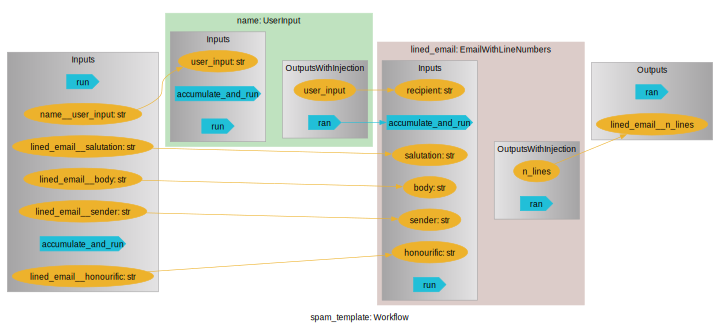

In [17]:
wf2.draw(size=(10,10))

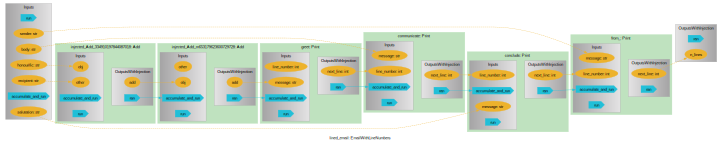

In [18]:
wf2.lined_email.draw(size=(10,10))

**Warning:** This similarity to how we define a `Function` node can be a bit dangerous -- the body of a `Function` node operates on its input each time the node runs and can hold arbitrary python code. In contrast, when we decorate a function to turn it into a `Macro` node, that function definition is run _once_ at instantiation of the macro, and from then the entire graph is what get executed when you run the node. A corollary is that the input to an `as_macro_node`-wrapped function is getting transformed into _data channels_ and is not the raw data like in a `Function` node! While almost all python operations are possible on a data channel, you can't do everything to it. In the same way, the return values of a macro need to all be data channels.

E.g. Returning a non-data-channel

In [19]:
try:
    @Workflow.wrap.as_macro_node("x", "y")
    def Foo(self, a):
        return a + 1, 6

    Foo()
except AttributeError:
    print("Returns a non-data-channel")

Returns a non-data-channel


Solution: honestly, it seems like a strange choice, since this will get run _once_ at instantiation then never updated. But if you really want to, you can always wrap it as a node and then return that:

In [20]:
@Workflow.wrap.as_macro_node("x", "y")
def Foo(self, a):
    self.six = Workflow.create.standard.UserInput(6)
    return a + 1, self.six

Foo()(a=1)

{'x': 2, 'y': 6}

E.g. A much more common problem is to mix-and-match valid macro defining code with some illegal operations:

In [21]:
try:
    @Workflow.wrap.as_macro_node
    def Foo(self, a):
        self.number = a + 1
        self.string = str(self.number)
        return self.string

    Foo()
except AttributeError:
    print("De-data-channels `a`")

De-data-channels `a`


Solution: This _looks_ like macro code, but `str()` is not a python operation, it's just some function. That means that `self.string` is actually just some the string representation of the `self.number` channel as it appears at macro instantiation, and (just like `6` above), not a valid return for a macro-defining function!

This is a common mistake, and basically just amounts to mixing-and-matching function and macro definition code. A simple solution is to simply extract the operation you want performed at each invocation of the graph as its own function node, and then include that in the macro!

In [22]:
@Workflow.wrap.as_function_node
def Stringify(a):
    as_string = str(a)
    return as_string

@Workflow.wrap.as_macro_node
def Foo(self, a):
    self.number = a + 1
    self.string = Stringify(self.number)
    return self.string

Foo()(1)

{'string': '2'}

# Storage

You've run you workflow and want to close your notebook for the day -- but you don't want to lose your data state. No problem! Just `.save()` your workflow. We'll go back and use our e-mail workflow as an example:

In [23]:
wf2.save()

This creates a new save-file at a canonical path based on your workflow's semantic labeling:

In [24]:
for item in wf2.as_path().iterdir():
    print(item)

/Users/huber/work/pyiron/pyiron_workflow/notebooks/spam_template/picklestorage.pckl


If you want to reload a `Macro` or `Function` node that you saved individually, you'll need to manually invoke the `.load` method, but by default new `Workflow` instances check to see if there's a save file available with their label:

In [25]:
wf2_reloaded = Workflow(wf2.label)
wf2_reloaded.outputs.to_value_dict()

{'lined_email__n_lines': 4}

If we want to avoid this, we could turn off the auto-loading (or, more brutally, `delete_existing_savefiles`)

In [26]:
wf_not_2 = Workflow(wf2.label, autoload=None)
wf_not_2.outputs.to_value_dict()

{}

And we can delete the save-files manually 

In [27]:
wf2.delete_storage()

wf2.as_path().exists()

False

You can manually save any child node, or you can use `checkpoint` to specify a backend to use for saving the parent-most graph whenever a child finishes running:

In [28]:
wf = Workflow("checkpointed")
wf.a = Workflow.create.standard.UserInput(42)
wf.b = wf.a + 1
wf.c = wf.b + 1

wf.b.checkpoint = "pickle"
wf()

{'c__add': 44}

On reload, we'll see that the save occured after `b` but before `a`:

In [29]:
reload_checkpointed = Workflow(wf.label)
for n in reload_checkpointed:
    print(n.label, n.outputs.to_value_dict())

a {'user_input': 42}
b {'add': 43}
c {'add': NOT_DATA}


In [30]:
# Lastly, just clean up after ourselves
reload_checkpointed.delete_storage()

Note that we've specified a `"pickle"` storage back-end for saving the workflow. This is -- almost -- exactly what it sounds like: we're just pickling the workflow. If needed, this interface will fall back on `cloudpickle`. This comes with all the same downsides as `pickle`. The trivial one is that we have saved a workflow that uses nodes _defined in `__main__`_, i.e. in this notebook. Until you re-execute those cells, you won't be able to successfully load the workflow in a fresh python interpreter session.

More seriously, `pickle` doesn't come with any built-in versioning control. That means it is **unsuitable for long-term-storage**. `pickle` is just re-importing and re-instantiating classes, so there is no robustness against the underlying node source code changing between save and load time.

Finding/writing a hierarchical, browsable, and versioned storage interface is on our radar, but not currently available. In the meantime, your workflows themselves can be robustly versioned by storing your node and workflow definitions in `.py` files in a git repo, perhaps released as a versioned python package. If you have a robust way of storing your mission-critical input and associated workflow output data, storing this data and the workflow source code provides an intermediate step to reproducibility.

# Parallelization

`pyiron_workflow` actually splits apart data channels and the flow of data from "signal" channels and the flow of execution. This is important for while-loop flows, and if you want to learn more go check out the `deepdive.ipynb`. Most of the time, workflows form a Directed Acyclic Graph (DAG), and this execution flow can be completely automated -- you only need to define the flow of data.

This also means that it's quite easy to parallelize the execution of your workflow. Nodes each carry an `executor` attribute that is compatible with and `concurrent.futures.Executor` that implements a compliant `submit` method and returns a `concurrent.futures.Future` object, e.g. `concurrent.futures.ThreadPoolExecutor` and `concurrent.futures.ProcessPoolExecutor`, but also the more powerful `executorlib.Executor` from elsewhere in the pyiron project. Shortcuts to all three of these live on the `Workflow.create` menu.

Let's cook up a simple example to demonstrate this:

In [31]:
@Workflow.wrap.as_function_node
def Report(t1, t2, t3):
    tmax = max(t1, t2, t3)
    print("LONGEST", tmax)
    return tmax

wf = Workflow("sleepy")
wf.t_sleep = Workflow.create.standard.UserInput(2)
wf.a1 = Workflow.create.standard.Sleep(wf.t_sleep)
wf.a2 = Workflow.create.standard.Sleep(wf.t_sleep)
wf.a3 = Workflow.create.standard.Sleep(wf.t_sleep)
wf.midway = Report(wf.a1, wf.a2, wf.a3)
wf.b1 = Workflow.create.standard.Sleep(wf.midway)
wf.b2 = Workflow.create.standard.Sleep(wf.midway)
wf.b3 = Workflow.create.standard.Sleep(wf.midway)
wf.end = Report(wf.b1, wf.b2, wf.b3)

from time import time

t0 = time()

with Workflow.create.ThreadPoolExecutor(max_workers=3) as exe:
    for n in wf:
        if n.label not in ["t_sleep", "midway", "finally"]:
            n.executor = exe
    wf()
    
print("Total runtime", time() - t0)

LONGEST 2
LONGEST 2
Total runtime 4.039653062820435


We can see that each of the layers who were concurrent in data were also able to execute concurrently in time, with minimal overhead.

Note that here we do need to use a `ThreadPoolExecutor` (or something more powerful like `executorlib`) and not `ProcessPoolExecutor`. This can be understood by thinking back to the storage section: the `ProcessPoolExecutor` leverages the same serialization as `pickle`, but starts a _fresh python instance_ -- this fresh instance has no access to the `Report` node we defined in this notebook! This is perfectly reasonable behaviour for `ProcessPoolExecutor`, but is an easy "gotcha". Using the more powerful executor, or moving your nodes over to a `.py` file they can be imported from are both reasonable solutions.

# For-loops

You can quickly iterate over node instances to get a `pandas.DataFrame` linking looped input to output (non-looped input is accessible elsewhere, like in the node's input channels). This comes in two flavours: nested loops with `iter`:

In [32]:
n = Workflow.create.standard.Add()
n.iter(obj=[1, 2], other=[3, 4])

,obj,other,add
0,1,3,4
1,1,4,5
2,2,3,5
3,2,4,6


And zipped loops with `zip`:

In [33]:
n.zip(obj=[1, 2, 3], other=[4, 5, 6])

,obj,other,add
0,1,4,5
1,2,5,7
2,3,6,9


In both cases, the same input kwargs are used as in usual calls, but the values passed to them should be iterable.

This is fine for rapid prototyping, but doesn't give us access to the actual `For`-node itself -- we just get the dataframe. That means you can't use it inside, e.g., a `Macro`. For a more permanent solution you need to explicitly create a new `For`-node instance. This isn't quite as snappy as the instance-method syntax above, but follows the exact same pattern:

In [34]:
@Workflow.wrap.as_macro_node
def InternallyIterates(self, data: list[int], start: int = 0):
    self.iter_add = Workflow.create.for_node(
        body_node_class=Workflow.create.standard.Add,
        iter_on=("other",),  # Make sure it's a tuple, even if it's alone
        obj=start,
        other=data
    )
    self.zip_add = Workflow.create.for_node(
        body_node_class=Workflow.create.standard.Add,
        zip_on=("obj", "other"),
        obj=data,
        other=data
    )
    return self.iter_add, self.zip_add

macro_with_for_loops = InternallyIterates()

with Workflow.create.ThreadPoolExecutor(max_workers=1) as exe:
    macro_with_for_loops.iter_add.body_node_executor = exe
    out = macro_with_for_loops(data=[1, 2, 3])

Of course, one can combine these zipping on some input and nesting iteratively on others (just provide both kwargs), but this example is too simple to require that.

The for-loop nodes have fixed IO, just like everything else (except `Workflow`), but their body graph gets recreated on each run to accommodate the length of the input provided. Above we also snuck in an executor for the body nodes, not because it's at all necessary here, but just to demonstrate the syntax.

Outputs are `pandas.DataFrame` objects, just like for the `iter` and `zip` method calls:

In [35]:
out.iter_add

,other,add
0,1,1
1,2,2
2,3,3


In [36]:
out.zip_add

,obj,other,add
0,1,1,2
1,2,2,4
2,3,3,6


The execultion flow is available both prospectively (by the graph diagram), and retrospectively in terms of either the order in which nodes started executing

In [37]:
macro_with_for_loops.provenance_by_execution

['data', 'zip_add', 'iter_add']

or the order in which they finished executing (although these only differ for a given graph if executors are used and runtimes vary)

In [38]:
macro_with_for_loops.iter_add.provenance_by_completion

['obj',
 'other',
 'injected_GetItem_m1444423571754200676',
 'injected_GetItem_m951361650396068516',
 'injected_GetItem_m6695671005174904809',
 'body_2',
 'row_collector_2',
 'body_1',
 'body_0',
 'row_collector_1',
 'row_collector_0',
 'dataframe']

## What else?

To learn more, e.g. how to handle cyclic graphs, take a look at the `deepdive.ipynb` notebook, and/or start looking through the class docstrings. 